<a href="https://colab.research.google.com/github/eportah/Bird-of-Prey-Identifier/blob/main/inspectPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup dataset

#mount the drive to retrieve dataset
from google.colab import drive
drive.mount('/content/drive')

#import ZipFile to read dataset
from zipfile import ZipFile

#establish paths
zipPath = "/content/drive/MyDrive/MachineLearning/Datasets/birdsDatasets.zip"
extractPath = "/content/extractPath"

#extract and open dataset in read mode using ZipFile
with ZipFile(zipPath, 'r') as zipObj:
   zipObj.extractall(extractPath)

Mounted at /content/drive


In [2]:
#load dataset

#cell output rundown
"""
- Dataset has 300 files (images) split into 2 classes.
- Class names are 'birdsOfPrey' and 'notBirdsOfPrey'.
- Images are batched into groups of 32, resized to 224x224 pixels, with 3 color channels RGB.
- Labels are stored in 1-D array of length 32, one label per image in the batch.
"""

#store dataset path into variable and import tensorflow to load images from directory
datasetDirectory = "/content/extractPath/birdsDataset"
import tensorflow as tf

#load dataset with function image_dataset_from_directory and establish both image size and batch size
trainDataset = tf.keras.utils.image_dataset_from_directory(datasetDirectory, image_size=(224,224), batch_size=32)

#preview what got loaded and what dataset looks like
class_names = trainDataset.class_names
print("Class names:", class_names)
for images, labels in trainDataset.take(1):
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)

Found 300 files belonging to 2 classes.
Class names: ['birdsOfPrey', 'notBirdsOfPrey']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [3]:
#split dataset

#cell output rundown
"""
- 210, 70% for training
- 90, 30% for validation
- Batch sizes are the same for both training and validation
"""

#load training dataset, 70% of data
trainingDataset = tf.keras.utils.image_dataset_from_directory(
   datasetDirectory,
   validation_split=0.3,
   subset="training",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#load validation dataset, 30% of data
validationDataset = tf.keras.utils.image_dataset_from_directory(
   datasetDirectory,
   validation_split=0.3,
   subset="validation",
   seed=123,
   image_size=(224,224),
   batch_size=32
)

#preview one batch from training dataset
print("Training batch shapes:")
for imagesTrain, labelsTrain in trainingDataset.take(1):
  print("Images:", imagesTrain.shape)
  print("Labels:", labelsTrain.shape)

#preview one batch from validation dataset
print("Validation batch shapes:")
for imagesVal, labelsVal in validationDataset.take(1):
 print("Images:", imagesVal.shape)
 print("Labels:", labelsVal.shape)

Found 300 files belonging to 2 classes.
Using 210 files for training.
Found 300 files belonging to 2 classes.
Using 90 files for validation.
Training batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)
Validation batch shapes:
Images: (32, 224, 224, 3)
Labels: (32,)


In [4]:
#preprocess dataset

#import MobileNetV2 preprocessing
from keras.applications.mobilenet_v2 import preprocess_input

#define dataAugmentation
dataAugmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.1),
   tf.keras.layers.RandomZoom(0.1)
])

#apply augmentation and MobileNetV2 preprocessing to training set using map to transform batches of images
trainSet = trainingDataset.map(lambda x, y: (preprocess_input(dataAugmentation(x)),y))

#apply MobileNetV2 preprocessing to validation set still using map to transform batches of images
validSet = validationDataset.map(lambda x, y: (preprocess_input(x),y))

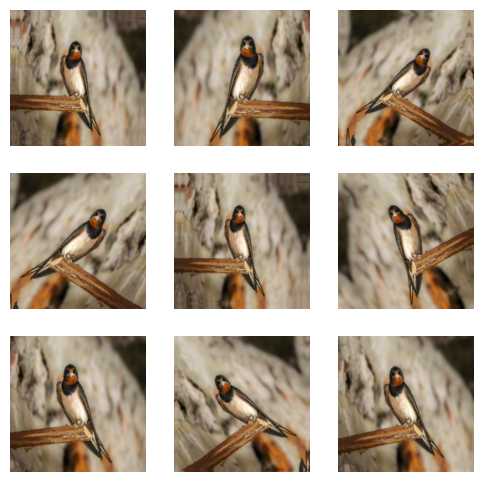

In [5]:
#preview augmentation

#import pyplot to visualize tensors as images and numpy for numpy indexing
import matplotlib.pyplot as plt
import numpy as np

#take one raw image from unmapped training dataset and select first image and its label, shape (224, 224, 3)
for imgs, labs in trainingDataset.take(1):
  batchImages = imgs.numpy()
  batchLabels = labs.numpy()
sampleImage = batchImages[0]
sampleLabel = batchLabels[0]

#establish grid and create a figure for plotting
augmentedNum = 9
plt.figure(figsize = (6,6))

#add batch dimension and apply augmentation
for i in range(augmentedNum):
  imgBatch = np.expand_dims(sampleImage, axis = 0)
  imgAugmented = dataAugmentation(imgBatch)[0].numpy()

  #clip to ensure values are within range and cast to convert the aray from floats to 8-bit unsigned integers
  imgAugmented = np.clip(imgAugmented, 0, 255).astype("uint8")

  #finish off by plotting each augmented image in a 3x3 grid
  axes = plt.subplot(3,3, i+1)
  axes.imshow(imgAugmented)
  axes.axis('off')

In [6]:
#build model

#import MobileNetV2 to use as base
from keras.applications import MobileNetV2
from keras import layers, models

#load base MobiletNetV2 and drop original classifier
baseModel = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

#freeze base so pretrained weights are not trained right away
baseModel.trainable = False

#add custom classifier head by using layers
"""
Rectified linear unit relu to prevent exploding values
Softmax to turn output into probabilites that add up to 1, each value shows chances an image could belong to a class
Dense layer to learn how much each feature matters for classying a species with another
GAP2D to squeeze feature maps into single vector per channel instead of flattening huge tensors
Dropout to randomly turn off 30% neurons during training to prevent overfitting
"""
model = models.Sequential([
    baseModel,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation = 'softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
#compile model

#import optimizers to use Adam
from keras import optimizers

#.compile for optimizer, loss, metrics
"""
Set learning rate to 0.0001 to avoid ruining pretrained weights
Sparse categorical crossentropy since classes are labeled as integers
Accuracy metric to track model performance
"""
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [8]:
#train model

#cell output rundown
"""
Training data divided into batches of images (batch size = 32)
7 batches per epoch
Model updates its weights after each batch
Over epochs, accuracy increases and loss decreases
Validation accuracy starts high due to pretrained MobileNetV2 base
"""

#set 15 epochs to get started and change depending on how it fits
epochs = 15

#fit the model with training history
"""
history stores loss and accuracy curves to be plotted later
"""
history = model.fit(
    trainSet,
    validation_data = validSet,
    epochs = epochs
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2823 - loss: 1.6684 - val_accuracy: 0.5889 - val_loss: 1.0707
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6770 - loss: 0.8326 - val_accuracy: 0.6556 - val_loss: 0.7788
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6560 - loss: 0.7651 - val_accuracy: 0.7222 - val_loss: 0.6341
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7313 - loss: 0.5902 - val_accuracy: 0.7889 - val_loss: 0.5232
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7724 - loss: 0.4939 - val_accuracy: 0.8333 - val_loss: 0.4474
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8254 - loss: 0.4137 - val_accuracy: 0.8444 - val_loss: 0.4011
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8789 - loss: 0.3391 - val_accuracy: 0.8556 - val_loss: 0.3685
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9128 - loss: 0.2493 - val_accuracy: 0.8556 - val_loss: 0.3545
Epoch 9/

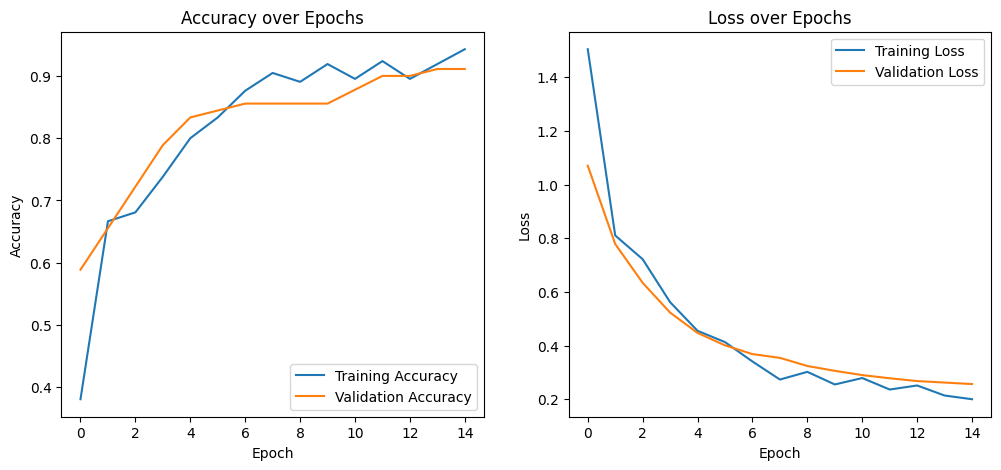

In [9]:
#evaluate curves

#extract metrics from history
acc = history.history['accuracy']
valAcc = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']

#number of epochs
epochsRange = range(len(acc))

#plot accuracy and loss
plt.figure(figsize=(12, 5))

#accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochsRange, acc, label = 'Training Accuracy')
plt.plot(epochsRange, valAcc, label = 'Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochsRange, loss, label = 'Training Loss')
plt.plot(epochsRange, valLoss, label = 'Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


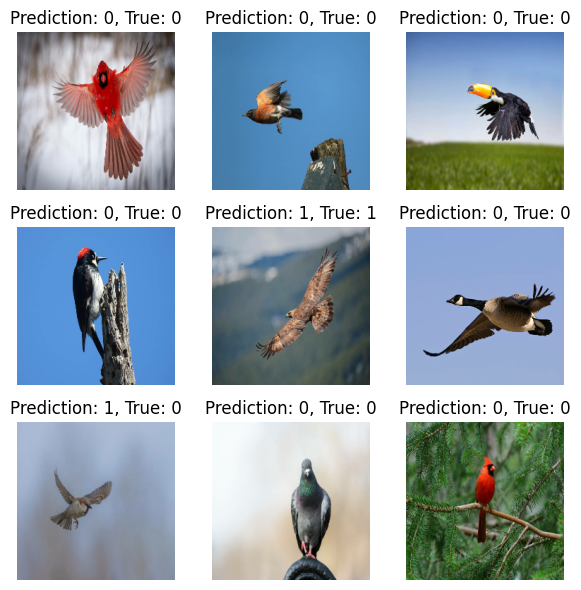

In [10]:
#inspect predictions

#cell output rundown
"""
3x3 grid of 9 birds
Prediction compared with ground truth
If correctly predicted, values (1 or 0) align
birdsOfPrey, 1
notBirdsOfPrey, 0
"""

#take batch from validation set
"""
.predict to get probabilities
.argmax to get predicted class
axis=1 to look across columns for each row
actual (true) labels is ground truth
"""
for images, labels in validSet.take(1):
  predictions = model.predict(images)
  predictedLabels = np.argmax(predictions, axis=1)
  actualLabels = labels.numpy()
  imagesBatch = images.numpy()

#flip labels so that birdsOfPrey = 1
predictedLabels = 1 - predictedLabels
actualLabels = 1- actualLabels

#plot first 9 images in batch with prediction vs ground truth
"""
Show first 9 images in batch for simplicity
(images_batch[i]+1)/2 to convert from [-1,1] to [0,1]
Fstring to format labels
True for ground truth
.axis off to hide unwanted ticks and labels
"""
plt.figure(figsize=(6,6))
for i in range(9):
  axes = plt.subplot(3, 3, i+1)
  plt.imshow((imagesBatch[i]+1)/2)
  plt.title(f"Prediction: {predictedLabels[i]}, True: {actualLabels[i]}")
  plt.axis('off')

#tight layout so nothing overlaps
plt.tight_layout()
plt.show()